# QAOA HW02 — Depth–Noise Tradeoff (Final Consolidated Notebook)

**What this notebook does (end-to-end):**
- Implements **QAOA for weighted MaxCut** (cost via ZZ, mixer via RX).
- Optimizes angles with **COBYLA** (robust to SciPy result-field differences); warm-starts across p.
- Builds **12 instances** = 4 topologies × 3 weight models; sizes within 5–10 nodes by default.
- Runs **ideal** (statevector) optimization and **noisy** evaluation (IBM-like fake-device noise with fallback).
- Logs **Approximation Ratio (AR)**, **circuit depth**, and **two-qubit gates** for each p.
- Provides **robust plotting** with built-in diagnostics (so empty plots are explained instead of silently blank).
- Includes **scale-up knobs** to run bigger experiments (more p, shots, sizes, seeds).

> Tip: Run top-to-bottom. You can tune `CONFIG` and the “Scale-up knobs” section to push larger runs.


---

In [1]:
# %% [markdown]
# ## 1) Setup & Global Defaults

import sys, math, itertools, random, os
from dataclasses import dataclass
import numpy as np

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['savefig.dpi'] = 300
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
    set_matplotlib_formats('retina')
except Exception:
    pass

import networkx as nx

# Qiskit (core) — notebook remains readable if missing
try:
    import qiskit
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Statevector
    QISKIT_AVAILABLE = True
except Exception as e:
    QISKIT_AVAILABLE = False
    print("Qiskit not available. Install: pip install qiskit qiskit-aer networkx scipy matplotlib pandas")
    print("Import error:", e)

# Aer / Noise (optional)
try:
    from qiskit_aer import AerSimulator
    from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
    AER_AVAILABLE = True
except Exception:
    AerSimulator = None
    NoiseModel = None
    AER_AVAILABLE = False

# SciPy optimizer (optional)
try:
    from scipy.optimize import minimize
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

# pandas (optional)
try:
    import pandas as pd
    PANDAS_AVAILABLE = True
except Exception:
    PANDAS_AVAILABLE = False
    print("pandas not available; CSV export disabled.")

print("Seed =", SEED, "| Qiskit:", QISKIT_AVAILABLE, "| Aer:", AER_AVAILABLE, "| SciPy:", SCIPY_AVAILABLE, "| pandas:", PANDAS_AVAILABLE)


Seed = 123 | Qiskit: True | Aer: True | SciPy: True | pandas: True


In [2]:
# %% [markdown]
# ## 2) Graph Generators + Weight Models (4 topologies × 3 weight strategies)

def make_unweighted_graph(topology: str, n: int, seed: int = SEED, *, p_er: float = 0.5, d_reg: int = 3, m_ba: int = 1):
    if topology == "er":
        G = nx.erdos_renyi_graph(n, p_er, seed=seed)
    elif topology == "regular":
        if (n * d_reg) % 2 != 0:
            raise ValueError("For a d-regular graph, n*d must be even.")
        G = nx.random_regular_graph(d_reg, n, seed=seed)
    elif topology == "complete":
        G = nx.complete_graph(n)
    elif topology == "ba":
        m_ba = max(1, min(m_ba, n-1))
        G = nx.barabasi_albert_graph(n, m_ba, seed=seed)
    else:
        raise ValueError(f"Unknown topology: {topology}")
    return G

# Toggle near the top of your notebook
USE_NONNEG_WEIGHTS = True

def assign_weights(G: nx.Graph, model: str, seed: int = SEED, *, nonnegative: bool = False):
    rng = np.random.default_rng(seed)
    for u, v in G.edges():
        if model == "rademacher":
            w = 1.0 if rng.random() < 0.5 else -1.0
        elif model == "uniform":
            w = rng.uniform(-1.0, 1.0)
        elif model == "gaussian":
            w = rng.normal(0.0, 1.0)
        else:
            raise ValueError(f"Unknown weight model: {model}")
        if nonnegative:
            w = abs(w)
        G[u][v]["weight"] = float(w)
    return G

def make_weighted_graph(topology: str, n: int, weight_model: str, seed: int = SEED, **kwargs) -> nx.Graph:
    G = make_unweighted_graph(topology, n, seed=seed, **kwargs)
    assign_weights(G, weight_model, seed=seed, nonnegative=USE_NONNEG_WEIGHTS)
    return G

def graph_info(G: nx.Graph):
    n = G.number_of_nodes(); m = G.number_of_edges()
    degs = [d for _, d in G.degree()]
    print(f"Graph: n={n}, m={m}, avg_deg={np.mean(degs):.2f}, max_deg={np.max(degs)}")

def draw_graph(G: nx.Graph, figsize=(8,6), node_size=650, font_size=11):
    pos = nx.spring_layout(G, seed=SEED)
    plt.figure(figsize=figsize)
    nx.draw(G, pos, with_labels=True, node_color='lightgray', node_size=node_size, font_size=font_size)
    plt.title("Instance (weights not shown)")
    plt.tight_layout(); plt.show()


In [3]:
# %% [markdown]
# ## 3) Weighted MaxCut Utilities — scoring & brute-force optimum

import itertools

def cut_value(bitstr: str, G: nx.Graph) -> float:
    val = 0.0
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        if bitstr[u] != bitstr[v]:
            val += w
    return float(val)

def bruteforce_optimum(G: nx.Graph, limit_n: int = 12):
    n = G.number_of_nodes()
    if n > limit_n:
        raise ValueError(f"Graph too large for brute force (n={n} > {limit_n}).")
    best_val, best_bs = -1e18, None
    for bits in itertools.product('01', repeat=n):
        bs = ''.join(bits)
        v = cut_value(bs, G)
        if v > best_val:
            best_val, best_bs = v, bs
    return float(best_val), best_bs


In [4]:
# %% [markdown]
# ## 4) QAOA Ansatz (weighted MaxCut)

def qaoa_cost_layer(qc, gamma: float, G: nx.Graph):
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1.0)
        qc.rzz(2.0 * gamma * w, u, v)

def qaoa_mixer_layer(qc, beta: float, n: int):
    for i in range(n):
        qc.rx(2.0 * beta, i)

def build_qaoa_circuit(G: nx.Graph, gammas, betas, measure: bool = True):
    assert len(gammas) == len(betas)
    n = G.number_of_nodes()
    qc = QuantumCircuit(n, n) if measure else QuantumCircuit(n)
    qc.h(range(n))
    for g, b in zip(gammas, betas):
        qaoa_cost_layer(qc, float(g), G)
        qaoa_mixer_layer(qc, float(b), n)
    if measure:
        qc.measure(range(n), range(n))
    return qc


In [5]:
# %% [markdown]
# ## 5) Expectation Evaluation (statevector & sampling)

def expected_cut_statevector(G: nx.Graph, gammas, betas) -> float:
    if not QISKIT_AVAILABLE:
        raise RuntimeError("Qiskit not available here.")
    qc = build_qaoa_circuit(G, gammas, betas, measure=False)
    sv = Statevector.from_instruction(qc)
    probs = sv.probabilities()
    n = G.number_of_nodes()
    exp_val = 0.0
    for idx, p in enumerate(probs):
        bs = format(idx, f'0{n}b')
        exp_val += p * cut_value(bs, G)
    return float(exp_val)

def expected_cut_sampling(G: nx.Graph, gammas, betas, shots: int = 2048, backend=None, seed: int = SEED) -> float:
    if not QISKIT_AVAILABLE:
        raise RuntimeError("Qiskit not available here.")
    if backend is None:
        if not AER_AVAILABLE:
            raise RuntimeError("qiskit-aer not available for sampling backend.")
        backend = AerSimulator()
    qc = build_qaoa_circuit(G, gammas, betas, measure=True)
    tqc = transpile(qc, backend=backend, seed_transpiler=seed)
    result = backend.run(tqc, shots=int(shots), seed_simulator=seed).result()
    counts = result.get_counts()
    total = sum(counts.values())
    n = G.number_of_nodes()
    exp_val = 0.0
    for key, c in counts.items():
        bs = key[::-1] if isinstance(key, str) else key  # reverse to index nodes 0..n-1
        exp_val += (c / total) * cut_value(bs, G)
    return float(exp_val)


In [6]:
# %% [markdown]
# ## 6) Optimizer (COBYLA; robust) + warm-starts (and optional sampling-objective variant)

def _pack_params(gammas, betas):
    return np.concatenate([np.array(gammas, dtype=float), np.array(betas, dtype=float)])

def _unpack_params(x):
    p = len(x)//2
    return x[:p], x[p:]

def _safe_getattr(res, name, default=None):
    try:
        return getattr(res, name)
    except Exception:
        try:
            return res[name]
        except Exception:
            return default

def expected_cut(G, gammas, betas, *, method="statevector", shots=1024, backend=None):
    if method == "statevector":
        return expected_cut_statevector(G, gammas, betas)
    elif method == "sampling":
        return expected_cut_sampling(G, gammas, betas, shots=shots, backend=backend)
    else:
        raise ValueError("method must be 'statevector' or 'sampling'")

def optimize_qaoa(G, p, *, init=None, method="statevector", shots=1024, backend=None, maxiter=120, seed=SEED):
    rng = np.random.default_rng(seed)
    if init is None:
        gammas0 = 0.7 * np.ones(p); betas0 = 0.5 * np.ones(p)
    else:
        gammas0, betas0 = init
        gammas0 = np.array(gammas0, dtype=float); betas0 = np.array(betas0, dtype=float)

    def obj(x):
        g, b = _unpack_params(x)
        return -float(expected_cut(G, g, b, method=method, shots=shots, backend=backend))

    x0 = _pack_params(gammas0, betas0)

    if SCIPY_AVAILABLE:
        res = minimize(obj, x0, method="COBYLA", options={"maxiter": int(maxiter), "rhobeg": 0.2, "tol": 1e-3})
        x_best = _safe_getattr(res, "x", x0); fun = _safe_getattr(res, "fun", None)
        g_opt, b_opt = _unpack_params(x_best)
        best_val = -float(fun) if fun is not None else expected_cut(G, g_opt, b_opt, method=method, shots=shots, backend=backend)
        info = {"success": bool(_safe_getattr(res, "success", False)), "nit": _safe_getattr(res, "nit", None),
                "nfev": _safe_getattr(res, "nfev", None), "status": _safe_getattr(res, "status", None),
                "message": str(_safe_getattr(res, "message", "")), "optimizer": "COBYLA"}
    else:
        best_val, g_opt, b_opt = -1e9, None, None
        for _ in range(int(maxiter)):
            x = x0 + 0.25 * rng.normal(size=x0.shape)
            v = -obj(x)
            if v > best_val:
                best_val = v; g_opt, b_opt = _unpack_params(x)
        info = {"success": True, "nit": int(maxiter), "message": "random-search fallback", "optimizer": "random"}

    return (np.array(g_opt), np.array(b_opt)), float(best_val), info

def warm_start(prev_g, prev_b):
    p = len(prev_g)
    rng = np.random.default_rng(SEED + p)
    return np.append(prev_g, np.mean(prev_g) + 0.05*rng.normal()), np.append(prev_b, np.mean(prev_b) + 0.05*rng.normal())

# Optional: sampling-based optimization (slower, more physical)
def optimize_qaoa_sampling_objective(G, p, *, init=None, shots=2048, backend=None, maxiter=120, seed=SEED):
    rng = np.random.default_rng(seed)
    if init is None:
        gammas0 = 0.7 * np.ones(p); betas0 = 0.5 * np.ones(p)
    else:
        gammas0, betas0 = init
        gammas0 = np.array(gammas0, dtype=float); betas0 = np.array(betas0, dtype=float)

    def obj(x):
        g, b = x[:p], x[p:]
        val = expected_cut_sampling(G, g, b, shots=shots, backend=backend, seed=seed)
        return -float(val)

    x0 = np.concatenate([gammas0, betas0])

    if SCIPY_AVAILABLE:
        res = minimize(obj, x0, method="COBYLA", options={"maxiter": int(maxiter), "rhobeg": 0.2, "tol": 1e-3})
        x_best = res.x
        g_opt, b_opt = x_best[:p], x_best[p:]
        best_val = -float(res.fun)
        info = {"success": bool(getattr(res, "success", False)), "optimizer": "COBYLA(sampling)"}
    else:
        best_val, g_opt, b_opt = -1e9, None, None
        for _ in range(int(maxiter)):
            x = x0 + 0.25 * rng.normal(size=x0.shape)
            v = -obj(x)
            if v > best_val:
                best_val = v; g_opt, b_opt = x[:p], x[p:]
        info = {"success": True, "optimizer": "random(sampling)"}
    return (np.array(g_opt), np.array(b_opt)), float(best_val), info


In [7]:
# %% [markdown]
# ## 7) Noise Models: IBM fake-device → lightweight fallback

def make_ibm_like_backends(preferred=("FakeManila","FakeNairobi","FakeJakarta","FakeKolkata")):
    if not AER_AVAILABLE or not QISKIT_AVAILABLE:
        return None, None, None, "Aer/Qiskit unavailable."

    fake_backend = None
    for name in preferred:
        # Try modern fake_provider
        try:
            from qiskit.providers.fake_provider import __dict__ as _fp_dict
            FakeCls = _fp_dict.get(name) or _fp_dict.get(name + "V2")
            if FakeCls is not None:
                fake_backend = FakeCls(); break
        except Exception:
            pass
        # Try legacy
        if fake_backend is None:
            try:
                from qiskit.test.mock import __dict__ as _old_dict
                FakeCls = _old_dict.get(name)
                if FakeCls is not None:
                    fake_backend = FakeCls(); break
            except Exception:
                pass

    if fake_backend is None:
        # Synthetic fallback
        ideal = AerSimulator()
        nm = NoiseModel()
        err1 = depolarizing_error(0.001, 1); err2 = depolarizing_error(0.01, 2)
        ro  = ReadoutError([[0.98,0.02],[0.02,0.98]])
        for g in ["id","rx","ry","rz","x","sx","h"]:
            nm.add_all_qubit_quantum_error(err1, g)
        for g2 in ["cx","rzz"]:
            nm.add_all_qubit_quantum_error(err2, g2)
        nm.add_all_qubit_readout_error(ro)
        noisy = AerSimulator(noise_model=nm, basis_gates=nm.basis_gates)
        return ideal, noisy, None, "Using lightweight synthetic noise."

    try:
        nm = NoiseModel.from_backend(fake_backend)
        noisy = AerSimulator(noise_model=nm, basis_gates=nm.basis_gates)
        ideal = AerSimulator()
        name = getattr(fake_backend.configuration(), 'backend_name', str(fake_backend))
        return ideal, noisy, name, "Using IBM fake-device noise model."
    except Exception as e:
        ideal = AerSimulator()
        nm = NoiseModel()
        err1 = depolarizing_error(0.001, 1); err2 = depolarizing_error(0.01, 2)
        ro  = ReadoutError([[0.98,0.02],[0.02,0.98]])
        for g in ["id","rx","ry","rz","x","sx","h"]:
            nm.add_all_qubit_quantum_error(err1, g)
        for g2 in ["cx","rzz"]:
            nm.add_all_qubit_quantum_error(err2, g2)
        nm.add_all_qubit_readout_error(ro)
        noisy = AerSimulator(noise_model=nm, basis_gates=nm.basis_gates)
        return ideal, noisy, None, f"Synthetic noise due to error: {e}"


In [8]:
# %% [markdown]
# ## 8) Circuit Metrics (depth & two-qubit gate counts)

def circuit_metrics(G: nx.Graph, gammas, betas, backend=None, seed: int = SEED):
    if not QISKIT_AVAILABLE:
        raise RuntimeError("Qiskit not available.")
    qc = build_qaoa_circuit(G, gammas, betas, measure=True)
    tqc = transpile(qc, backend=backend, seed_transpiler=seed) if backend is not None else transpile(qc, seed_transpiler=seed)
    counts = tqc.count_ops()
    depth = int(tqc.depth())
    twoq = int(counts.get("cx", 0) + counts.get("rzz", 0))
    return {"depth": depth, "twoq": twoq, "ops": dict(counts)}


In [9]:
# %% [markdown]
# ## 9) Experiment Harness (12 instances) — config & runner

@dataclass
class InstanceSpec:
    topology: str
    weight: str
    n: int
    seed: int = SEED

TOPOLOGIES = ["er", "regular", "complete", "ba"]
WEIGHTS    = ["rademacher", "uniform", "gaussian"]

# Choose sizes per topology (within 5–10 by default; adjust in Scale-up knobs)
DEFAULT_SIZES = {"er": 8, "regular": 8, "complete": 7, "ba": 9}

def make_12_instances(sizes=DEFAULT_SIZES, seed=SEED):
    inst = []
    for topo in TOPOLOGIES:
        for w in WEIGHTS:
            inst.append(InstanceSpec(topo, w, sizes[topo], seed))
    return inst

CONFIG = {
    "p_list": (1,2,3,4,5),   # depth sweep
    "shots_noisy": 1024,     # sampling shots for noisy evaluation
    "maxiter": 120,          # COBYLA budget
    "sizes": DEFAULT_SIZES,
}

def run_qaoa_instance(G, p_list, *, ideal_backend, noisy_backend, maxiter=120, shots_noisy=1024, seed=SEED):
    rows = []
    opt_val, _ = bruteforce_optimum(G, limit_n=12)
    g_init, b_init = None, None

    for p in p_list:
        if g_init is None:
            init = (0.7*np.ones(p), 0.5*np.ones(p))
        else:
            init = warm_start(g_init, b_init)

        (g_i, b_i), val_i, info_i = optimize_qaoa(G, p, init=init, method="statevector",
                                                  backend=ideal_backend, maxiter=maxiter, seed=seed)
        AR_i = float(val_i / opt_val) if abs(opt_val) > 1e-12 else np.nan

        if noisy_backend is not None:
            val_n = expected_cut_sampling(G, g_i, b_i, shots=shots_noisy, backend=noisy_backend, seed=seed)
            AR_n  = float(val_n / opt_val) if abs(opt_val) > 1e-12 else np.nan
        else:
            val_n, AR_n = None, np.nan

        m = circuit_metrics(G, g_i, b_i, backend=noisy_backend, seed=seed)

        rows.append({
            "n": G.number_of_nodes(), "p": p,
            "opt_cut": float(opt_val),
            "ideal_cut": float(val_i),
            "noisy_cut": (None if val_n is None else float(val_n)),
            "AR_ideal": AR_i, "AR_noisy": AR_n,
            "depth": m["depth"], "twoq": m["twoq"],
            "info": info_i,
        })
        g_init, b_init = g_i, b_i

    return rows

def make_instances_with_seeds(seeds=(101,202,303), sizes=DEFAULT_SIZES):
    inst = []
    for s in seeds:
        for topo in TOPOLOGIES:
            for w in WEIGHTS:
                inst.append(InstanceSpec(topo, w, sizes[topo], s))
    return inst

def run_full_experiment(config=CONFIG):
    sizes = config.get("sizes", DEFAULT_SIZES)
    p_list = config.get("p_list", (1,2,3,4,5))
    maxiter = int(config.get("maxiter", 120))
    shots_noisy = int(config.get("shots_noisy", 1024))

    instances = make_12_instances(sizes=sizes, seed=SEED)

    if AER_AVAILABLE and QISKIT_AVAILABLE:
        ideal_backend, noisy_backend, device_name, note = make_ibm_like_backends()
        print("Noise backend:", device_name or "synthetic", "|", note)
    else:
        ideal_backend = noisy_backend = None
        print("Aer/Qiskit unavailable: only ideal statevector will run.")

    rows = []
    for spec in instances:
        G = make_weighted_graph(spec.topology, spec.n, spec.weight, seed=spec.seed)
        res = run_qaoa_instance(G, p_list, ideal_backend=ideal_backend, noisy_backend=noisy_backend,
                                maxiter=maxiter, shots_noisy=shots_noisy, seed=spec.seed)
        for r in res:
            r.update({"topology": spec.topology, "weight": spec.weight, "seed": spec.seed})
        rows.extend(res)

    if PANDAS_AVAILABLE:
        return pd.DataFrame(rows)
    return rows

def run_full_experiment_with_seeds(config=CONFIG, seeds=(101,202,303)):
    sizes = config.get("sizes", DEFAULT_SIZES)
    p_list = config.get("p_list", (1,2,3,4,5))
    maxiter = int(config.get("maxiter", 120))
    shots_noisy = int(config.get("shots_noisy", 1024))

    instances = make_instances_with_seeds(seeds=seeds, sizes=sizes)

    if AER_AVAILABLE and QISKIT_AVAILABLE:
        ideal_backend, noisy_backend, device_name, note = make_ibm_like_backends()
        print("Noise backend:", device_name or "synthetic", "|", note)
    else:
        ideal_backend = noisy_backend = None
        print("Aer/Qiskit unavailable: only ideal statevector will run.")

    rows = []
    for spec in instances:
        G = make_weighted_graph(spec.topology, spec.n, spec.weight, seed=spec.seed)
        res = run_qaoa_instance(G, p_list, ideal_backend=ideal_backend, noisy_backend=noisy_backend,
                                maxiter=maxiter, shots_noisy=shots_noisy, seed=spec.seed)
        for r in res:
            r.update({"topology": spec.topology, "weight": spec.weight, "seed": spec.seed})
        rows.extend(res)

    if PANDAS_AVAILABLE:
        return pd.DataFrame(rows)
    return rows


In [10]:
# %% [markdown]
# ## 10) Robust Plotting, Diagnostics, and CSV Export

def sanitize_ar(df, eps=1e-12):
    """Set AR_* = NaN where opt_cut is too small to avoid misleading ratios."""
    ok = df["opt_cut"].to_numpy(dtype=float) > eps
    df.loc[~ok, "AR_ideal"] = np.nan
    df.loc[~ok, "AR_noisy"] = np.nan
    return df

def debug_instance(df, topology, weight):
    sub = df[(df.topology == topology) & (df.weight == weight)].sort_values("p")
    if sub.empty:
        print(f"[debug] No rows for {topology}, {weight}")
        return sub
    print(f"[debug] rows={len(sub)}, n={sub['n'].iloc[0]}, p_set={sorted(sub['p'].unique().tolist())}")
    print("[debug] opt_cut stats: min={:.6g}, max={:.6g}".format(sub["opt_cut"].min(), sub["opt_cut"].max()))
    print("[debug] AR_ideal finite? ->", np.isfinite(sub["AR_ideal"]).tolist())
    print("[debug] AR_noisy finite? ->", np.isfinite(sub["AR_noisy"]).tolist())
    return sub

def plot_ar_vs_p_robust(df, topology, weight, figsize=(8,5), ylim="auto"):
    """
    x-axis: p ; y-axis: Approximation Ratio (AR) = expected_cut / optimal_cut
    Blue solid: ideal (statevector-optimized); Orange dashed: noisy (same angles).
    """
    import numpy as np, matplotlib.pyplot as plt
    if not PANDAS_AVAILABLE:
        raise RuntimeError("pandas required for plotting.")

    sub = df[(df.topology == topology) & (df.weight == weight)].sort_values("p")
    if sub.empty:
        print(f"[debug] No rows for {topology}, {weight}"); return

    p   = sub["p"].to_numpy(float)
    ari = sub["AR_ideal"].to_numpy(float)
    arn = sub["AR_noisy"].to_numpy(float)
    n = int(sub["n"].iloc[0])

    mask_i = np.isfinite(ari)
    mask_n = np.isfinite(arn)

    plt.figure(figsize=figsize)
    if mask_i.any():
        plt.plot(p[mask_i], ari[mask_i], marker="o", label="ideal")
    if mask_n.any():
        plt.plot(p[mask_n], arn[mask_n], marker="s", linestyle="--", label="noisy")

    # ---- auto y-limits (so negative ARs are visible) ----
    if ylim == "auto":
        ys = np.concatenate([ari[mask_i], arn[mask_n]]) if (mask_i.any() or mask_n.any()) else np.array([0.0])
        ylo = float(np.nanmin(ys)); yhi = float(np.nanmax(ys))
        pad = max(0.05*(yhi - ylo if yhi>ylo else 1.0), 0.05)
        plt.ylim(ylo - pad, yhi + pad)
    elif isinstance(ylim, tuple):
        plt.ylim(*ylim)

    plt.title(f"AR vs p — {topology}, {weight}, n={n}")
    plt.xlabel("p"); plt.ylabel("Approximation Ratio (AR)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def export_all_instance_plots(df, outdir="figs"):
    if not PANDAS_AVAILABLE:
        raise RuntimeError("pandas required.")
    os.makedirs(outdir, exist_ok=True)
    paths = []
    for topo in TOPOLOGIES:
        for w in WEIGHTS:
            sub = df[(df.topology==topo)&(df.weight==w)].sort_values("p")
            if sub.empty: 
                continue
            p = sub["p"].to_numpy()
            ar_i = sub["AR_ideal"].to_numpy()
            ar_n = sub["AR_noisy"].to_numpy()
            n = int(sub["n"].iloc[0])

            plt.figure(figsize=(8,5))
            if np.isfinite(ar_i).any():
                plt.plot(p[np.isfinite(ar_i)], ar_i[np.isfinite(ar_i)], marker='o', label='ideal')
            if np.isfinite(ar_n).any():
                plt.plot(p[np.isfinite(ar_n)], ar_n[np.isfinite(ar_n)], marker='s', linestyle='--', label='noisy')
            plt.title(f"AR vs p — {topo}, {w}, n={n}")
            plt.xlabel("p"); plt.ylabel("Approximation Ratio (AR)"); plt.ylim(0,1.05)
            plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
            path = os.path.join(outdir, f"AR_vs_p__{topo}__{w}.png")
            plt.savefig(path, bbox_inches='tight'); plt.close()
            paths.append(path)
    print("Saved", len(paths), "figure(s) to:", outdir)
    return paths

def save_results_csv(df, path="qaoa_hw02_results.csv"):
    if not PANDAS_AVAILABLE:
        raise RuntimeError("pandas required.")
    df.to_csv(path, index=False); print("Saved:", path)


In [11]:
# Depth (hardest knob)
CONFIG["p_list"]      = (1,2,3,4,5,6,7)

# Noisy sampling shots (stabilizes curves)
CONFIG["shots_noisy"] = 4096

# Optimizer budget (tighter angles)
CONFIG["maxiter"]     = 300

# Graph sizes (still brute-forceable; keep n ≤ ~10–11)
DEFAULT_SIZES.update({"er": 10, "regular": 10, "complete": 9, "ba": 10})

# Multiple random seeds (more instances)
df = run_full_experiment_with_seeds(CONFIG, seeds=(101,202,303))


Noise backend: synthetic | Using lightweight synthetic noise.


Noise backend: synthetic | Using lightweight synthetic noise.


,n,p,opt_cut,ideal_cut,noisy_cut,AR_ideal,AR_noisy,depth,twoq,info,topology,weight,seed
0,10,1,17.000000,13.159585,13.124023,0.774093,0.772001,17,25,"{'success': True, 'nit': None, 'nfev': 29, 'st...",er,rademacher,123
1,10,2,17.000000,13.194510,13.291016,0.776148,0.781824,27,50,"{'success': True, 'nit': None, 'nfev': 51, 'st...",er,rademacher,123
2,10,3,17.000000,13.553223,14.081543,0.797248,0.828326,37,75,"{'success': False, 'nit': None, 'nfev': 300, '...",er,rademacher,123
3,10,4,17.000000,13.757057,13.664551,0.809239,0.803797,47,100,"{'success': False, 'nit': None, 'nfev': 300, '...",er,rademacher,123
4,10,5,17.000000,13.799022,13.546387,0.811707,0.796846,57,125,"{'success': False, 'nit': None, 'nfev': 300, '...",er,rademacher,123
5,10,6,17.000000,13.797606,13.403076,0.811624,0.788416,67,150,"{'success': False, 'nit': None, 'nfev': 300, '...",er,rademacher,123
6,10,7,17.000000,13.814268,13.349609,0.812604,0.785271,77,175,"{'success': False, 'nit': None, 'nfev': 300, '...",er,rademacher,123
7,10,1,9.579705,6.742011,6.453182,0.703781,0.673631,17,25,"{'success': True, 'nit': None, 'nfev': 29, 'st...",er,uniform,123
8,10,2,9.579705,6.887998,6.548502,0.719020,0.683581,27,50,"{'success': True, 'nit': None, 'nfev': 107, 's...",er,uniform,123
9,10,3,9.579705,7.003270,6.740794,0.731053,0.703654,37,75,"{'success': False, 'nit': None, 'nfev': 300, '...",er,uniform,123


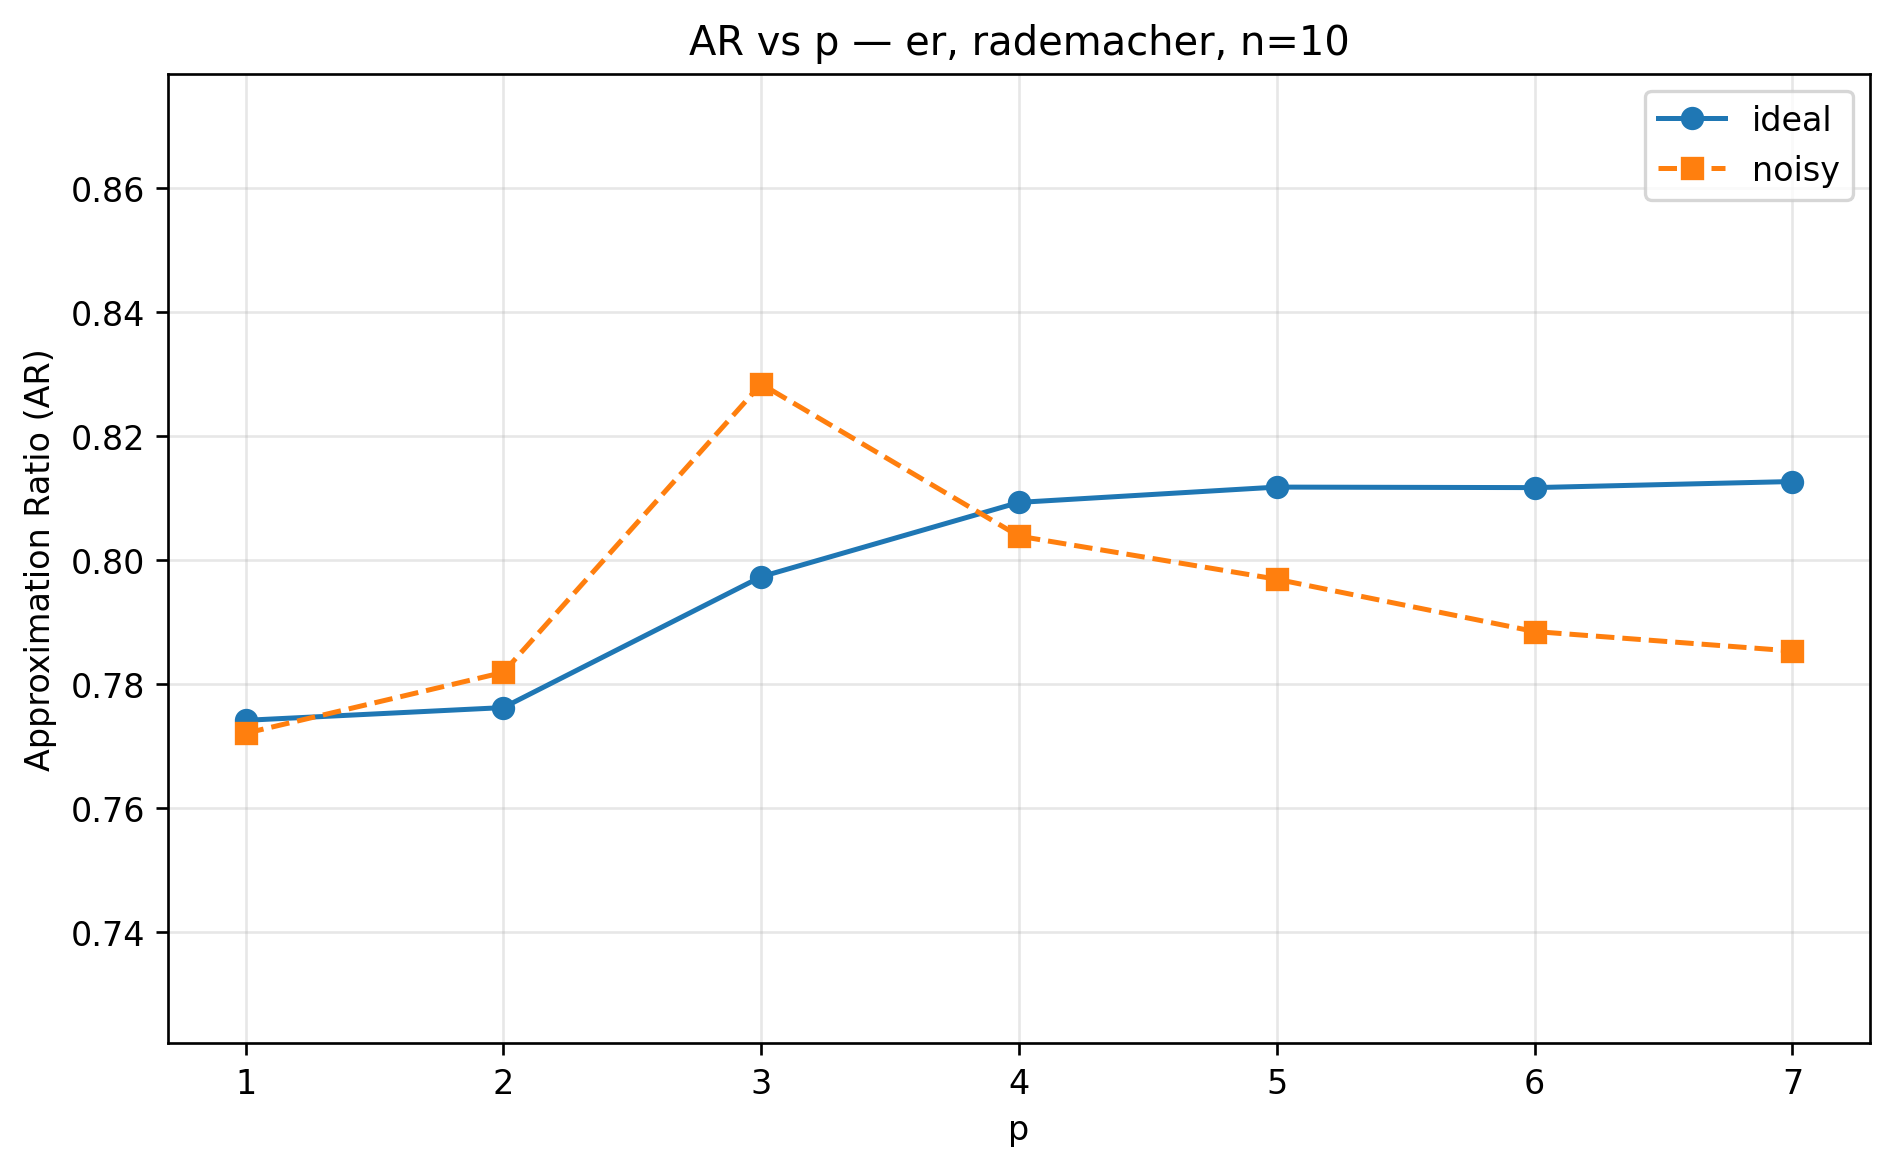

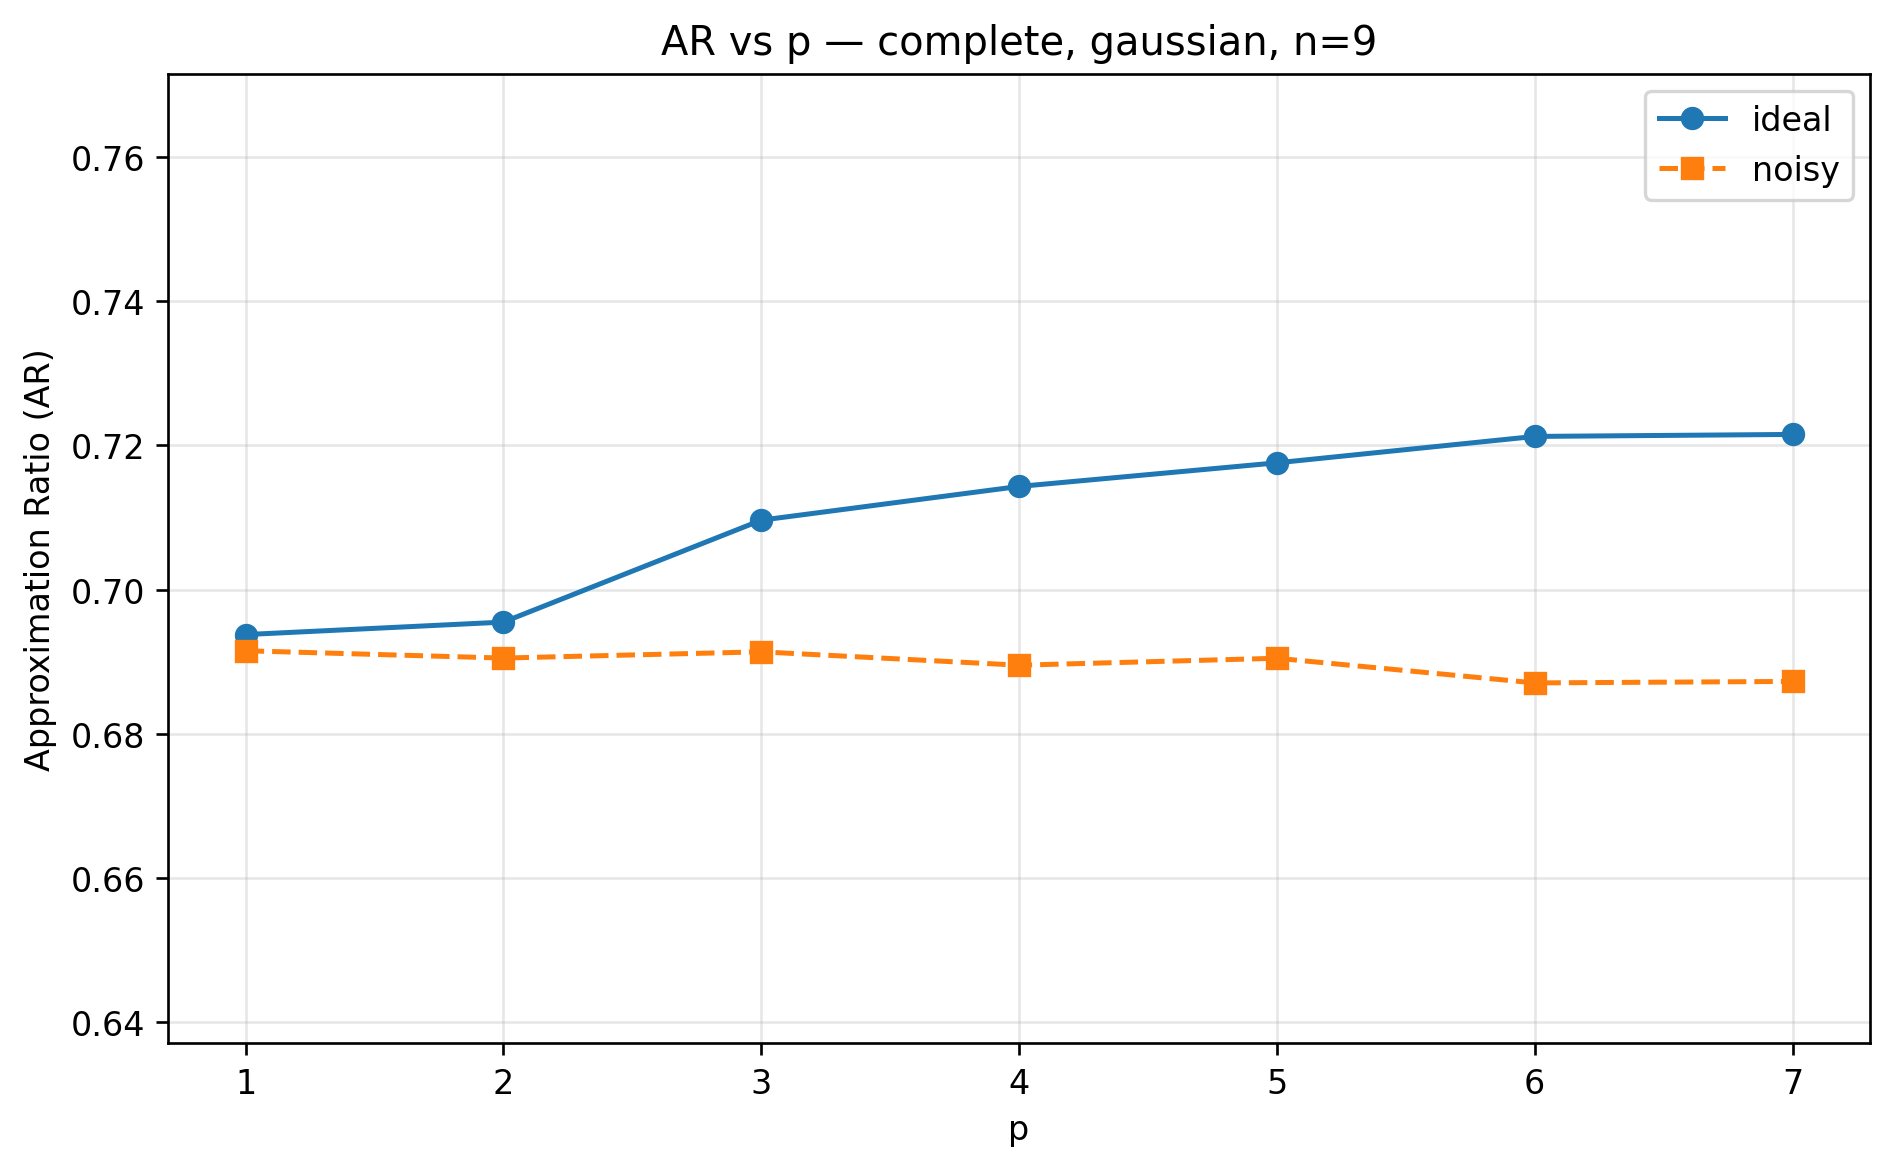

Saved 12 figure(s) to: figs
Saved: qaoa_hw02_results.csv


In [12]:
# %% [markdown]
# ## 12) Driver — run the 12-instance experiment and produce plots/CSV

df = run_full_experiment(CONFIG)
if PANDAS_AVAILABLE:
    df = sanitize_ar(df)
    try:
        from caas_jupyter_tools import display_dataframe_to_user as _display_df
        _display_df("QAOA HW02 results", df)
    except Exception:
        display(df.head(24))

    # Example: plot two instances with robust plotting
    plot_ar_vs_p_robust(df, topology="er",       weight="rademacher")
    plot_ar_vs_p_robust(df, topology="complete", weight="gaussian")

    # Export all figures + CSV
    export_all_instance_plots(df, outdir="figs")
    save_results_csv(df, "qaoa_hw02_results.csv")
else:
    print("Results (first 3 rows):", df[:3])
